# Integration of BCR data and GEX data

10x BCR data and 10x GEX data can borrow information from each other for better analysis. The example data sets used in this tutorial "BCR.data.rds" and "GEX.data.rds" can be downloaded from [here](https://yale.box.com/shared/static/6s8gzxxpfb3vmwx2izn9qur9teultzvu.zip). 10x BCR data and 10x GEX data can be combined together based on the cell barcodes. Considering the cell barcodes could be duplicated in multiple samples, we suggest concatenate sample id with cell id to ensure the uniqueness of cell barcode across multiple samples. An extra column “cell_id_unique”, concatenating sample id and cell id, can be added into BCR data:

In [3]:
## load libraries ####
rm(list=ls())
suppressPackageStartupMessages(library("dplyr"))
suppressPackageStartupMessages(library("ggplot2"))
suppressPackageStartupMessages(library("Seurat"))
suppressPackageStartupMessages(library("cowplot"))
suppressPackageStartupMessages(library("RColorBrewer"))
path.work = file.path("..","data")

BCR.data = readRDS(file.path(path.work, "BCR.data.rds"))
BCR.data = BCR.data %>% rowwise() %>%
            mutate(cell_id_unique = paste(sample, strsplit(cell_id, split = "-")[[1]][1], sep = "_"))

When gene expression data was processed, cell ids can be added a prefix of sample id to differentiate cells from different samples with the same cell barcode:
GEX.seuratObj <- RenameCells(object = GEX.seuratObj, add.cell.id = sample). We have added sample id to cell id in the example GEX data.

## 1. Integrate BCR data to GEX data in Seurat object

meta.data data slot in Seurat object contains meta data for each cell and is a good place to hold BCR data for cells. For example, we can indicate if a cell in GEX has a corresponding BCR or not by a column called “has_BCR”. If the column “has_BCR” is true, we can also add other BCR data information, such as clone lineage, mutation frequency, Isotype, etc, to the metadata slot in Seurat Object. 

explain use same airr standard col names, just prefix with BCR_

In [4]:
GEX.seuratObj = readRDS(file.path(path.work, "GEX.data.rds"))
match.index = match(Cells(GEX.seuratObj), BCR.data$cell_id_unique)
GEX.seuratObj$contains_bcr = !is.na(match.index)
clone.id = BCR.data$clone_id
GEX.seuratObj$bcr_clone_id = unlist(lapply(match.index, function(x){ifelse(is.na(x),NA, clone.id[x])}))
mu.freq = BCR.data$mu_freq
GEX.seuratObj$bcr_mu_freq = unlist(lapply(match.index,function(x){ifelse(is.na(x),NA, mu.freq[x])}))
isotype = BCR.data$isotype 
GEX.seuratObj$bcr_isotype = unlist(lapply(match.index,function(x){ifelse(is.na(x),NA, isotype[x])}))

After we integrate BCR data into Seurat object, we can highlight BCR cells in GEX UMAP plot to check if the annotation based on gene expressions of biomarker genes are accurated or not.

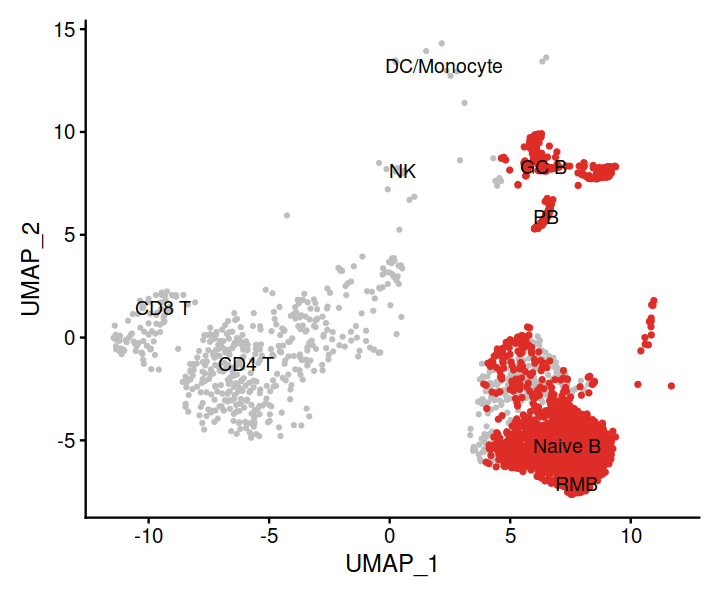

In [5]:
highlighted.cells = Cells(GEX.seuratObj) [which(GEX.seuratObj$contains_bcr)]
options(repr.plot.width=6, repr.plot.height=5)
DimPlot(object = GEX.seuratObj, reduction = "umap", cells.highlight = highlighted.cells, 
        label = TRUE, cols="gray", pt.size = 0.7,label.size=4) + NoLegend()

## 2. Integrate annotations of cells from GEX data to BCR data 

The annotation information of B cells, such as subtypes of B cells and their associated UMAP coordinates, identified by the gene expression data from 10x GEX, can be integrated into BCR data.

In [6]:
match.index = match(BCR.data$cell_id_unique, Cells(GEX.seuratObj))
BCR.data$has_gex = !is.na(match.index)
umap1 = GEX.seuratObj@reductions$umap@cell.embeddings[,1]
BCR.data$gex_umap1= unlist(lapply(match.index, function(x){ifelse(is.na(x), NA, umap1[x])}))
umap2 = GEX.seuratObj@reductions$umap@cell.embeddings[,2]
BCR.data$gex_umap2= unlist(lapply(match.index, function(x){ifelse(is.na(x),NA, umap2[x])}))
cell.annotation = as.character(Idents(GEX.seuratObj))
BCR.data$gex_annotation= unlist(lapply(match.index, function(x){ifelse(is.na(x),NA, cell.annotation[x])}))
BCR.data = filter(BCR.data, !is.na(gex_annotation))

With annotation information from gene expression data, we can layout cells from BCR data in a UMAP plot, with B cell subtypes in various colors.

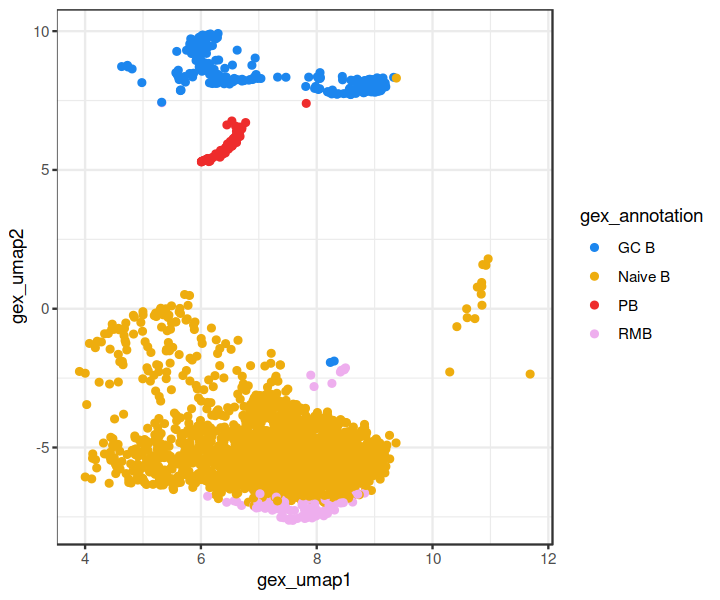

In [11]:
options(repr.plot.width=6, repr.plot.height=5)
col_anno = c("GC B"="dodgerblue2", "PB"="firebrick2", "ABC"="seagreen", 
                     "Naive B"="darkgoldenrod2", "RMB"="plum2")
ggplot()+
    geom_point(data = BCR.data,aes(x = gex_umap1, y = gex_umap2, color= gex_annotation))+
    scale_colour_manual(values = col_anno) +
    theme_bw()

Characteristics associated with BCR can be displayed in umap plot. The plots below show mutation frequency and isotypes of GC B cells at various time points.

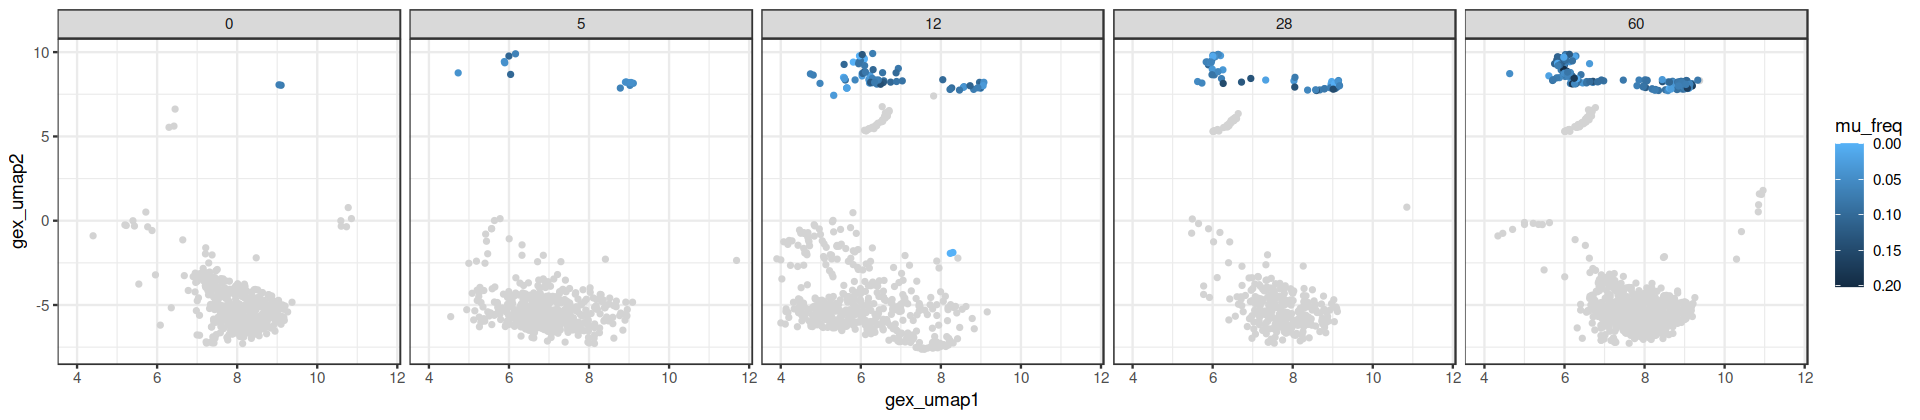

In [8]:
options(repr.plot.width=16, repr.plot.height=3.5)
ggplot()+
    geom_point(data = dplyr::filter(BCR.data, gex_annotation != "GC B"), aes(x = gex_umap1, y = gex_umap2), color="lightgray", size =1) +
    geom_point(data = dplyr::filter(BCR.data, gex_annotation =="GC B"), aes(x = gex_umap1, y = gex_umap2,  color = mu_freq), size =1) +
    theme_bw()+scale_colour_continuous(trans = 'reverse')+
    facet_wrap(~day,nrow=1)

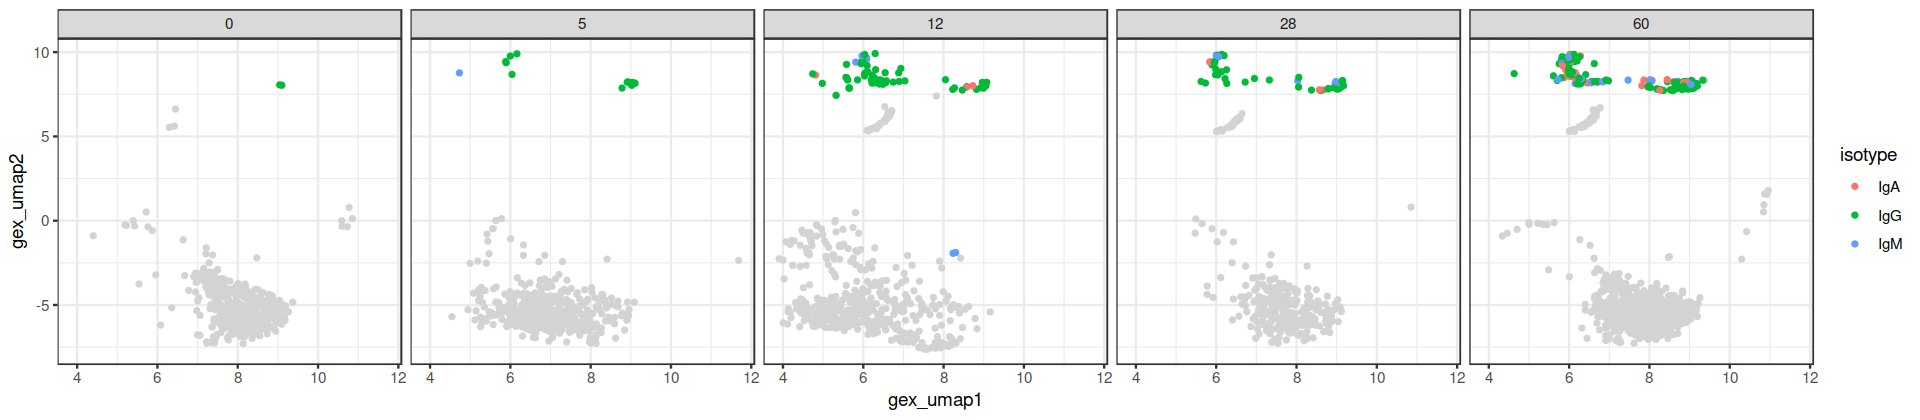

In [9]:
options(repr.plot.width=16, repr.plot.height=3.5)
ggplot()+
    geom_point(data = dplyr::filter(BCR.data, gex_annotation != "GC B"), aes(x = gex_umap1, y = gex_umap2), color="lightgray", size =1) +
    geom_point(data = dplyr::filter(BCR.data, gex_annotation =="GC B"), aes(x = gex_umap1, y = gex_umap2,  color = isotype), size =1) +
    theme_bw()+
    facet_wrap(~day,nrow=1)

## 